In [280]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.io import loadmat
from numpy.random import logistic
import random
from scipy.special import expit as sigmoid

# CS 189 Homework 4

In [9]:
w0 = np.array([-2.0, 1.0, 0.0])
lam = 0.07
X = np.array([[0,3,1], [1,3,1], [0,1,1], [1,1,1]])
y = np.array([1, 1, 0, 0])

s0 = sigmoid(np.dot(X, w0))

print('s0: ', s0)

w1 = w0 + np.dot(np.linalg.inv(2*lam*np.identity(3) + np.matmul(np.dot(X.T, np.diagflat(s0)), X)), (2*lam*w0 - np.dot(X.T, y - s0)))

print('w1: ',w1)

s1 = sigmoid(np.dot(X, w1))

print('s1: ',s1)

w2 = w1 + np.dot(np.linalg.inv(2*lam*np.identity(3) + np.dot(np.dot(X.T, np.diagflat(s1)), X)), (2*lam*w1 - np.dot(X.T, y - s1)))

print('w2: ',w2)

s0:  [0.95257413 0.73105858 0.73105858 0.26894142]
w1:  [-2.52944273  0.66772961  1.14165334]
s1:  [0.95870501 0.6491715  0.85928728 0.32737982]
w2:  [-3.24293197  0.19326062  2.67607706]


In [10]:
train_x, train_y, test_x = loadmat("data.mat")['X'], loadmat("data.mat")['y'], loadmat("data.mat")['X_test']

In [11]:
#train_x[0], train_y[0]

## Question 4: Wine Classification with Logistic Regression

### 4a) Batch GD

#### Batch GD Equation
#### Parameters: $\epsilon$ =  0.0001, iterations = 100000, $\lambda$  = 0.00006
### $ w = w -  \epsilon ( -X^T(y - s(Xw)) + 2\lambda w)  $

In [152]:
class GD_model:
    def __init__(self, d):
        self.w = np.array([random.random()*2 - 1 for i in range(d+1)]).reshape(d+1, 1)
        self.reg_param = 1
    
    def train(self, X, y, epsilon, iterations):
        X = np.insert(X, 12, 1, axis=1)
        for i in range(iterations):
            term = epsilon * self.cost(X, y, batch = True)
            self.w += term
            
    def reformat(self, x, batch = False):
        if batch:
            if np.shape(x)[1] < 13:
                x = np.insert(x, 12, 1, axis=1)
            x = np.reshape(x, (len(x), 13, 1))
        else:
            if len(x) < 13:
                x = np.append(x, 1)
            x = x.reshape(13, 1)
        return x

    def fn(self, x, batch = False):
        x = self.reformat(x, batch)
        if batch:
            x = np.reshape(x, (len(x), 13,))
            inner_term = np.matmul(x, self.w)
        else:
            inner_term = np.dot(x.T, self.w)
        output = sigmoid(inner_term).reshape(len(inner_term), 1)
        one_rep = 1 - np.finfo(float).eps
        np.place(output, output == 1.0, [one_rep])
        np.place(output, output == 0.0, [np.finfo(float).eps])
        return output
    
    def classify(self, x, tie_breaker, batch = False):
        x = self.reformat(x, batch)
        #print(x)
        f_out = self.fn(x, batch)
        return np.heaviside(f_out - 0.5, tie_breaker)
    
    def cost(self, X, y, batch = False):
        #gradient of cost
        lam = self.reg_param
        self.w.reshape(len(self.w), )
        answer = np.dot(X.T, y - self.fn(X, batch)) - (2*lam*self.w)
        self.w.reshape(len(self.w), 1)
        return answer
    
    def base_cost(self, X, y, batch = True):
        #regular cost
        lam = self.reg_param
        s = 0
        i = 0
        losses = self.loss(X, y, True)
        #print('nans', self.fn(X, batch)[np.argwhere(np.isnan(losses))])
        for row in X:
            l = losses[i]
            if np.isnan(l):
                print(self.fn(row))
            w = np.reshape(self.w, 13, )
            s += l + lam*np.inner(w, w)
            i += 1
        return s / i
            
    def loss(self, x, y, batch):
        #single value loss
        yhat = self.fn(x, batch)
        return -y * np.log(yhat) - (1-y)*np.log(1 - yhat)
    
    def cost_plot(self, X, y, iterations=800):
        epsilon = 0.0000001
        sizes = np.arange(1, iterations-1, 5)
        plt_y = np.array([])
        X = np.insert(X, 12, 1, axis=1)
        for i in range(iterations):
            term = self.cost(X, y, batch = True)
            self.w += term*epsilon
            if i in sizes:
                plt_y = np.append(plt_y, self.base_cost(X, y))
        plt.plot(sizes, plt_y, color = "red")
        plt.xlabel("Iterations")
        plt.ylabel("Cost (l2 regularized)")
        plt.title("Batched Gradient Descent Cost over time")
        
        #return (plt_y)
         

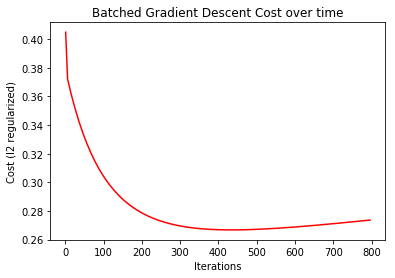

In [902]:
first_model = GD_model(len(train_x[0]))
first_model.cost_plot(train_x, train_y)

In [230]:
#first_model = GD_model(len(train_x[0]))
first_model.reg_param = 1
first_model.train(train_x, train_y, .0000001, 100000)
first_model.base_cost(train_x, train_y, batch = True)

array([18.03091292])

In [231]:
#Batch Gradient Descent Accuracy
e = 0
for i in range(len(train_x)):
    pred, real = first_model.classify(train_x[i], 1), train_y[i]
    #print("Real:{}, Prediction: {}".format(pred, real))
    if real == pred:
        e += 1
    else:
        pass
        #print(first_model.fn(train_x[i]), train_y[i])
e/i

0.9676612768794799

In [176]:
saved_params = first_model.w

In [229]:
saved_params

array([[333.76861208],
       [ 65.97028739],
       [ -7.60164012],
       [-37.23017301],
       [ 11.74687383],
       [ 11.55807342],
       [-37.59962368],
       [ 23.11108048],
       [104.71125119],
       [ 51.66538476],
       [ 15.34012231],
       [  2.2616782 ],
       [ 22.23356692]])

### 4b) Stochastic GD

## Update Rule

$w^{t+1} \leftarrow w^t - \epsilon \nabla_{w, i} J = w^t − \epsilon[−X_i^\intercal (y_i - s(X_iw)) + 2\lambda w]$

In [765]:
class SGD_model:
    def __init__(self, d):
        self.w = np.array([0.0]*(d+1)).reshape(d+1, 1)
    
    def train(self, X, y, epsilon, iterations):
        X = np.insert(X, 12, 1, axis=1)
        for i in range(iterations):
            index = np.random.randint(0, len(X), 1)
            term = epsilon * self.cost(X[index], y[index], batch = False)
            self.w += term
            
    def reformat(self, x, batch = False):
        if batch:
            if np.shape(x)[1] < 13:
                x = np.insert(x, 12, 1, axis=1)
            x = np.reshape(x, (len(x), 13, 1))
        else:
            x = np.ndarray.flatten(x)
            if len(x) < 13:
                x = np.append(x, 1)
            #print(x)
            
            x = x.reshape(13, 1)
        
        return x

    def fn(self, x, batch = False):
        x = self.reformat(x, batch)
        if batch:
            x = np.reshape(x, (len(x), 13,))
            inner_term = np.matmul(x, self.w)
        else:
            inner_term = np.dot(x.T, self.w)
        output = sigmoid(inner_term).reshape(len(inner_term), 1)
        np.place(output, output == 1.0, [0.9999999])
        np.place(output, output == 0.0, [0.00000001])
        return output
    
    def classify(self, x, batch = False):
        x = self.reformat(x, batch)
        #print(x)
        f_out = self.fn(x, batch)
        return np.heaviside(f_out - 0.5, 1)
    
    def cost(self, X, y, batch = False, lam = 0.0001):
        self.w.reshape(len(self.w), )
        answer = np.dot(X.T, y - self.fn(X, batch)) - (2*lam*self.w)
        self.w.reshape(len(self.w), 1)
        return answer
    
    def base_cost(self, X, y, batch = True, lam = 0.00006):
        s = 0
        i = 0
        losses = self.loss(X, y, True)
        #print('nans', self.fn(X, batch)[np.argwhere(np.isnan(losses))])
        for row in X:
            l = losses[i]
            if np.isnan(l):
                print(self.fn(row))
            w = np.reshape(self.w, 13, )
            s += l + lam*np.inner(w, w)
            i += 1
        return s / i
            
    def loss(self, x, y, batch):
        #single value loss
        yhat = self.fn(x, batch)
        return -y * np.log(yhat) - (1-y) * np.log(1 - yhat)
    
    def cost_plot(self, X, y, iterations=100001):
        epsilon = 0.0000001
        sizes = np.arange(200, iterations-1, 500)
        plt_y = np.array([])
        X = np.insert(X, 12, 1, axis=1)
        for i in range(iterations):
            term = self.cost(X, y, batch = True)
            self.w += term*epsilon
            if i in sizes:
                plt_y = np.append(plt_y, self.base_cost(X, y))
        plt.plot(sizes, plt_y, color="green")
        plt.title("Stochastic Gradient Descent Cost over Time")
        plt.xlabel("Iterations")
        plt.ylabel("Cost (l2 regularized)")
        
        #return (plt_y)
         

In [766]:
#second_model = SGD_model(12)
#second_model.train(train_x, train_y, 0.0001, 10000)

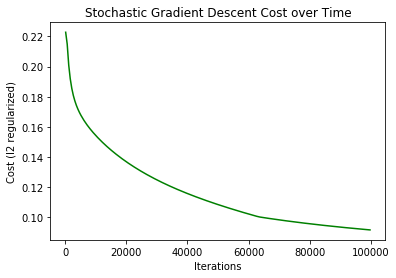

In [767]:
second_model = SGD_model(12)
second_model.cost_plot(train_x, train_y)

In [772]:
#Stochastic Gradient Descent Training Accuracy
e = 0
for i in range(len(train_x)):
    pred, real = second_model.classify(train_x[i]), train_y[i]
    #print("Real:{}, Prediction: {}".format(pred, real))
    if real == pred:
        e += 1
e/i

0.9736622770461744

### 4c) Decreasing Learning Rate

In [276]:
class SGD_dec_model:
    def __init__(self, d):
        self.w = np.array([0.0]*(d+1)).reshape(d+1, 1)
    
    def train(self, X, y, iterations):
        X = np.insert(X, 12, 1, axis=1)
        for i in range(1, iterations):
            index = np.random.randint(0, len(X), 1)
            term = 1/i * self.cost(X[index], y[index], batch = False)
            self.w += term
            
    def reformat(self, x, batch = False):
        if batch:
            if np.shape(x)[1] < 13:
                x = np.insert(x, 12, 1, axis=1)
            x = np.reshape(x, (len(x), 13, 1))
        else:
            x = np.ndarray.flatten(x)
            if len(x) < 13:
                x = np.append(x, 1)
            #print(x)
            
            x = x.reshape(13, 1)
        
        return x

    def fn(self, x, batch = False):
        x = self.reformat(x, batch)
        if batch:
            x = np.reshape(x, (len(x), 13,))
            inner_term = np.matmul(x, self.w)
        else:
            inner_term = np.dot(x.T, self.w)
        output = sigmoid(inner_term).reshape(len(inner_term), 1)
        np.place(output, output == 1.0, [0.9999999])
        np.place(output, output == 0.0, [0.00000001])
        return output
    
    def classify(self, x, batch = False):
        x = self.reformat(x, batch)
        #print(x)
        f_out = self.fn(x, batch)
        return np.heaviside(f_out - 0.5, 1)
    
    def cost(self, X, y, batch = False, lam = 0.06):
        self.w.reshape(len(self.w), )
        answer = np.dot(X.T, y - self.fn(X, batch)) - (2*lam*self.w)
        self.w.reshape(len(self.w), 1)
        return answer
    
    def base_cost(self, X, y, batch = True, lam = 0.00006):
        s = 0
        i = 0
        losses = self.loss(X, y, True)
        #print('nans', self.fn(X, batch)[np.argwhere(np.isnan(losses))])
        for row in X:
            l = losses[i]
            if np.isnan(l):
                print(self.fn(row))
            w = np.reshape(self.w, 13, )
            s += l + lam*np.inner(w, w)
            i += 1
        return s / i
            
    def loss(self, x, y, batch):
        #single value loss
        yhat = self.fn(x, batch)
        return -y * np.log(yhat) - (1-y) * np.log(1 - yhat)
    
    def cost_plot(self, X, y, iterations=100001):
        epsilon = 100
        sizes = np.arange(8000, iterations-1, 300)
        plt_y = np.array([])
        X = np.insert(X, 12, 1, axis=1)
        for i in range(1, iterations):
            term = self.cost(X, y, batch = True)
            self.w += term * epsilon/i
            if i in sizes:
                plt_y = np.append(plt_y, self.base_cost(X, y))
        plt.plot(sizes, plt_y)
        plt.title("Decreasing Learning Rate Cost over Time")
        plt.xlabel("Iterations")
        plt.ylabel("Cost (l2 regularized)")
        print(plt_y[-1], '= final cost')
         

95.68242719028704 = final cost


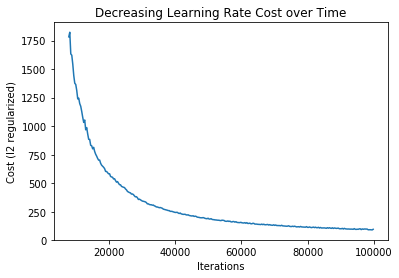

In [277]:
third_model = SGD_dec_model(12)
third_model.cost_plot(train_x, train_y)

In [279]:
#Stochastic Gradient Descent with Decreasing Learning Rate Training Accuracy
#third_model.train(train_x, train_y, 10000)
e = 0
for i in range(len(train_x)):
    pred, real = third_model.classify(train_x[i]), train_y[i]
    #print("Real:{}, Prediction: {}".format(pred, real))
    if real == pred:
        e += 1
e/i

0.9483247207867977

### The cost seems to be converging to a larger value than the previous version of SGD. This must be due to the relatively large starting step sizes.

## 4d) Kaggle

Done with 1e-07
Done with 5e-07
Done with 1e-05
Done with 2e-05
Done with 5e-05
Done with 0.001
Done with 0.07
Done with 0.1
Done with 1
Done with 2
Done with 5


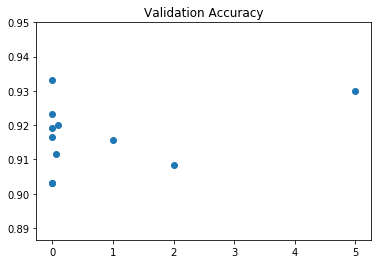

In [179]:
#Validation for BGD
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

shuffled_x, shuffled_y = unison_shuffled_copies(train_x, train_y)
split = int(len(shuffled_x)*0.8)
val_x, val_y = shuffled_x[split:], shuffled_y[split:]
temp_trainx, temp_trainy = shuffled_x[:split], shuffled_y[:split]

ploty = []
lams = [0.0000001, 0.0000005, 0.00001, 0.00002, 0.00005, 0.001, 0.07, 0.1, 1, 2, 5, 10, 20]
for lam in lams:
    model = GD_model(12)
    model.reg_param = lam
    model.train(temp_trainx, temp_trainy, 0.0000001, 5000)
    
    e = 0
    for i in range(len(val_x)):
        pred, real = model.classify(val_x[i], 1), val_y[i]
        #print("Real:{}, Prediction: {}".format(pred, real))
        if real == pred:
            e += 1
    ploty.append(e/i)
    
    print("Done with {}".format(lam))
    
plt.scatter(lams, ploty)
plt.title("Validation Accuracy")
plt.show()

In [185]:
# A code snippet to help you save your results into a kaggle accepted csv
import pandas as pd
import numpy as np

# Usage results_to_csv(clf.predict(X_test))
def results_to_csv(y_test, string):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1  # Ensures that the index starts at 1. 
    df.to_csv(string + '_submission.csv', index_label='Id')

def model_export(model, test_x, string = ""):
    ans = np.array([float(model.classify(point, 1)) for point in test_x])
    results_to_csv(ans, string)

In [186]:
model_export(first_model, test_x, "up to 9846 percent")

2.220446049250313e-16